# Homework 5
#### Neural Signal Processing
#### Ana Daniela del Río Pulido

A relevant note is to make the distinction between eigenvalue ($\lambda$) and singular value ($s$). They are not the same, and to make the precise distinction:
$$s^2 = \lambda$$

In [1]:
import os.path
import scipy.io
import pandas as pd
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

https://elec548.github.io/Assignments/hw5.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Example using PCA: https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python


# Exercise 1

For Problem 1 of this assignment, you will again use the reach data from HW 3 (in file ReachData.npz on Canvas).

Visualization of high-dimensional neural activity using PCA (30 pts) For this problem, you will again use the reach data from HW 5 (in file ReachData.npz on Canvas). Begin by extracting the “plan” data for all trials and all targets. Use a constant length window 200 ms long starting 50 ms after the timeTouchHeld. You should end up with a matrix of N×K, where N is the number of neurons and K is the total number of trials.

In [2]:
spikeTimes = np.load('HW3_files/spikeTimes.npy', allow_pickle=True)
timeGoCue = np.load('HW3_files/timeGoCue.npy', allow_pickle=True)
timeTargetAcquire = np.load('HW3_files/timeTargetAcquire.npy', allow_pickle=True)
timeTouchHeld = np.load('HW3_files/timeTouchHeld.npy', allow_pickle=True)
cfr = np.load('HW3_files/cfr.npy', allow_pickle=True)

In [3]:
np.shape(spikeTimes)

(1127, 190)

In [4]:
# Modified example code for finding the number of spikes in the plan window

planSpikes = []

for trialIdx, trialSpikes in enumerate(spikeTimes):
    planSpikes.append([np.sum((st > timeTouchHeld[trialIdx]+50) & (st < timeTouchHeld[trialIdx]+250)) for st in trialSpikes])

planSpikes = np.array(planSpikes) # will be 1127 x 190 (number of trials by number of neurons)
# movementSpikes = np.array(movementSpikes) # will be 1127 x 190 (number of trials by number of neurons)
# planSpikes, movementSpikes

In [5]:
print(np.shape(planSpikes)) # total number of trials * number of neurons
print(np.shape(planSpikes.T)) # number of neurons * total number of trials

(1127, 190)
(190, 1127)


a. Calculate the principal components of the neural activity (there is a PCA decomposition within sklearn, but you can also just use the numpy.linalg.eig function). Plot the square-rooted eigenvalue spectrum. If you had to identify an elbow in the eigenvalue spectrum, how many dominant eigenvalues would there be? What percentage of the overall variance is captured by the top 3 principal components?

In [6]:
pca = PCA()
pca.fit(planSpikes.T)

PCA()

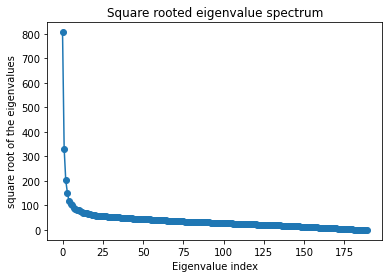

In [7]:
plt.plot(pca.singular_values_, marker="o")
plt.title("Square rooted eigenvalue spectrum")
plt.xlabel("Eigenvalue index")
plt.ylabel("square root of the eigenvalues")
plt.show()

We can determine the elbow depending on when the rate of change does not change much from one point to the next
This is the same convergence criterium used in HW4 for the cost funtion, just that we will change the weight, instead of being 0.001, we could change it to 0.2. It must simply be a small value, close to zero and less than 1.

``` np.abs(J[i-1]-J[i])< 0.001*J[i]```

In [8]:
for i in range(len(pca.singular_values_)):
    if (pca.singular_values_[i] - pca.singular_values_[i+2])/pca.singular_values_[i+2] < 0.2:
        print("The elbow in the eigenvalue spectrum is in eigenvalue #"+str(i+1))
        break

The elbow in the eigenvalue spectrum is in eigenvalue #5


The percentage of overall variance that is captured by the top 3 principal components is:

In [9]:
100*np.sum(pca.explained_variance_ratio_[0:3])

72.94408158232211

In [10]:
# Note how the sum of the whole explained_variance_ratio_ adds up to one.
np.sum(pca.explained_variance_ratio_)

0.9999999999999998

b. For the purposes of visualization, we’ll consider the PC space defined by the top M = 3 eigenvectors. Project the data into the three-dimensional PC space. Plot the projected points in a 3D plot (example here) and color each dot appropriately according to reaching target. Rotate the axes (example here) to show a view in which the clusters are well-separated.

http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html

http://matplotlib.org/examples/mplot3d/rotate_axes3d_demo.html

(1127, 190)
(190, 3)


<IPython.core.display.Javascript object>


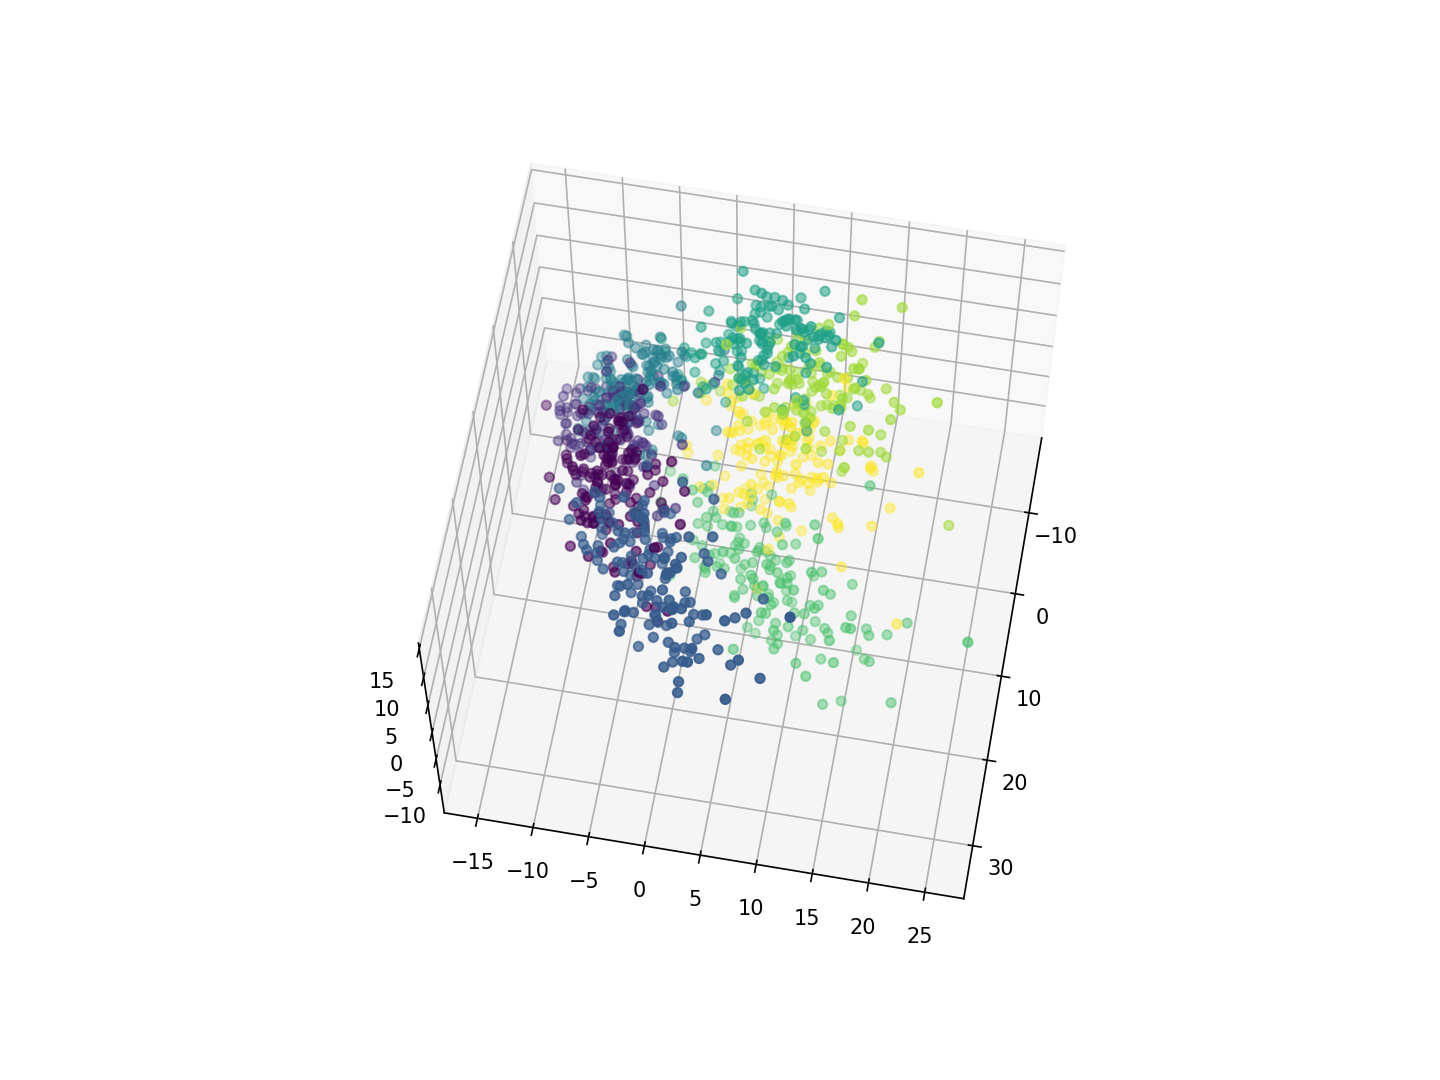

In [12]:
pca = PCA(n_components=3)
pca.fit(planSpikes)
print(planSpikes.shape)

eigenvectors = pca.components_.T
print(eigenvectors.shape)

# These two expressions for z are equivalent
# z = np.matmul(planSpikes, eigenvectors)

# Based on Caleb's code for projecting
subtraction = planSpikes - np.mean(planSpikes,axis=0)
z = subtraction.dot(eigenvectors[:,:3])

%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(z[:,0],z[:,1], z[:,2], c = cfr)
plt.show()

c. Define a matrix UM∈RD×M
containing the top three eigenvectors (i.e., PC directions), where UM(d,m) indicates the contribution of the dth neuron to the mth principal component. Show the values in UM, e.g., by calling imshow(UM )’. (Note: Also call colorbar’ to show the scale.) Are there are any obvious groupings among the neurons in each column of UM?

In [13]:
UM = pca.components_.T
np.shape(UM)

(190, 3)

<IPython.core.display.Javascript object>


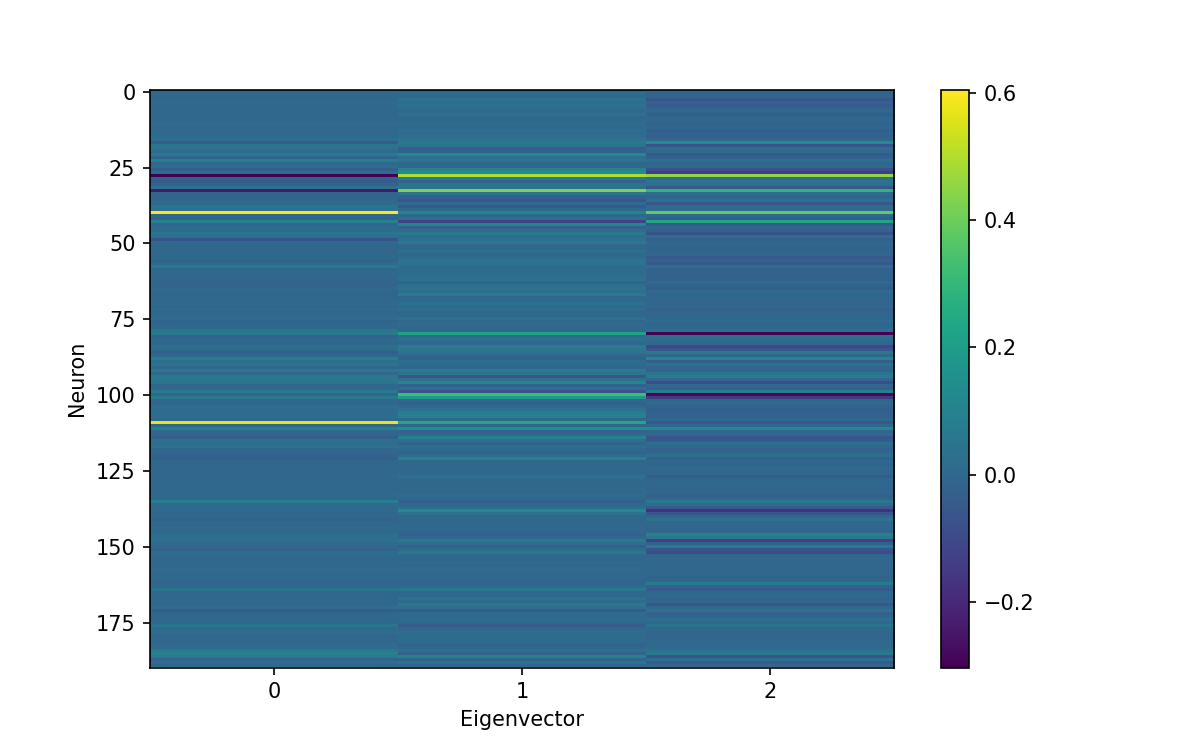

In [14]:
plt.figure(figsize=(8,5))
plt.imshow(UM, aspect="auto") # Bigger, but the colors smooth
plt.ylabel("Neuron")
plt.xlabel("Eigenvector")
plt.xticks([0,1,2])
plt.colorbar()
plt.show()

Now, we'll comment about the groupings.

Notice there are some distinct neurons that contribute greatly to the eigenvectors. And if it is a color close to yellow, they contribute positively, and when the color is close to dark blue, they contribute negatively. The neurons that have a green-blue color, have a contribution of 0 to the eigenvectors, i.e. they are not contributing.

# Exercise 2
For Problem 2, you will use the datasets from HW4, SpikeData05.npz and SpikeData12.npz, which contain numpy arrays SpikeWaveforms and RawData. (The raw data was too large to upload. It is available on request.)

a) Begin with the data from the numpy file SpikeData05.npz. Use the first 5000 samples. Calculate the principal components of the spike waveforms on the first tetrode channel. Plot the square-rooted eigenvalue spectrum. If you had to identify an elbow in the eigenvalue spectrum, how many dominant eigenvalues would there be? What percentage of the overall variance is captured by the top 3 principal components?

In [15]:
SpikeWaveforms = np.load('HW4_files/SpikeWaveforms05.npy', allow_pickle=True)
print(np.shape(SpikeWaveforms))
# AP detected, time, electrode

(33787, 40, 4)


In [16]:
np.shape(SpikeWaveforms[0:5000,:,0])
first_tetrode = SpikeWaveforms[0:5000,:,0]

# pca = PCA(n_components=3)
pca = PCA()
pca.fit(first_tetrode)
print(first_tetrode.shape)

eigenvectors = pca.components_.T
print(eigenvectors.shape)

# Based on Caleb's code for projecting
subtraction = first_tetrode - np.mean(first_tetrode,axis=0)
z = subtraction.dot(eigenvectors[:,:3])

(5000, 40)
(40, 40)


<IPython.core.display.Javascript object>


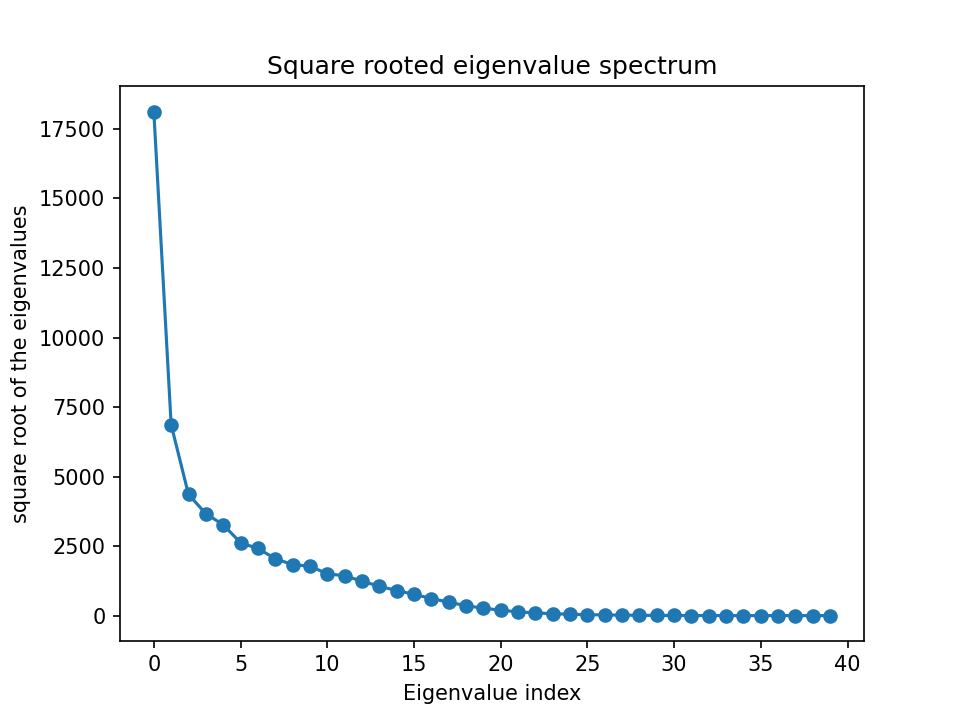

In [17]:
plt.plot(pca.singular_values_, marker="o")
plt.xlabel("Eigenvalue index")
plt.ylabel("square root of the eigenvalues")
plt.title("Square rooted eigenvalue spectrum")
plt.show()

In [18]:
for i in range(len(pca.singular_values_)):
    if (pca.singular_values_[i] - pca.singular_values_[i+2])/pca.singular_values_[i+2] < 0.3:
        print("The elbow in the eigenvalue spectrum is in eigenvalue #"+str(i+1))
        break

The elbow in the eigenvalue spectrum is in eigenvalue #6


In [19]:
100*np.sum(pca.explained_variance_ratio_[0:2])

83.21466331950008

Even though the criterium for the elbow of the eigenvalue spectrum is in eigenvalue #6, we could consider there are only 2 dominant eigenvalues, because the percentage of overall variance is 83%. 

The percentage of overall variance that is captured by the top 3 principal components is:

In [20]:
100*np.sum(pca.explained_variance_ratio_[0:3])

87.42080076726462

b. Plot the mean and the first 2 principal components. What do they look like?

<IPython.core.display.Javascript object>


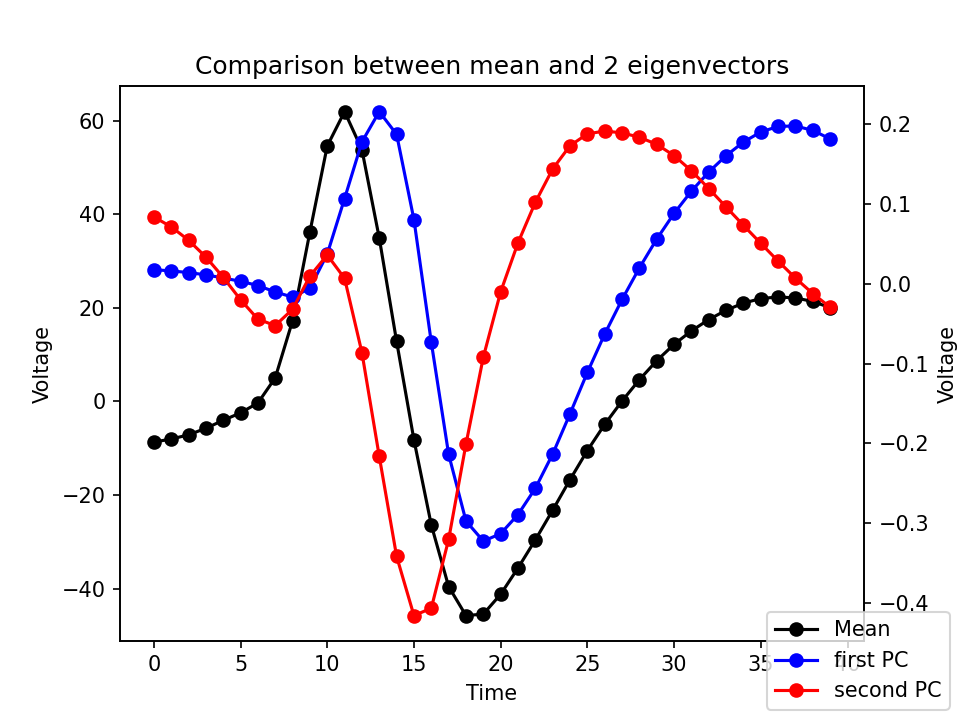

In [21]:
# Twin axis based on: https://www.geeksforgeeks.org/use-different-y-axes-on-the-left-and-right-of-a-matplotlib-plot/
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Time') 
ax1.set_ylabel('Voltage') 
ax1.plot(np.mean(first_tetrode,axis=0), marker="o", label="Mean", color="k") #[60,-40]
  
ax2 = ax1.twinx()   
ax2.set_ylabel('Voltage') 
ax2.plot(eigenvectors[:,0], marker="o", label="first PC", color="b") #[0.2,-0.4]
ax2.plot(eigenvectors[:,1], marker="o", label="second PC", color="r") 

plt.title("Comparison between mean and 2 eigenvectors")
fig.legend(loc="lower right")
plt.show()

Notice the first two eigenvectors look like action potential waveforms, very similar to the mean of our data. The only detail is that the scale of the eigenvectors is smaller than the scale of our mean data.

c. Now repeat the process for the first 5000 samples in SpikeData12.npz, again just using the first tetrode channel. Are there any major differences?

In [22]:
SpikeWaveforms = np.load('HW4_files/SpikeWaveforms12.npy', allow_pickle=True)
print(np.shape(SpikeWaveforms))
# AP detected, time, electrode

np.shape(SpikeWaveforms[0:5000,:,0])
first_tetrode = SpikeWaveforms[0:5000,:,0]


pca_ft = PCA()
pca_ft.fit(first_tetrode)
print(first_tetrode.shape)

eigenvectors_ft = pca_ft.components_.T
print(eigenvectors_ft.shape)

# Based on Caleb's code for projecting
subtraction = first_tetrode - np.mean(first_tetrode,axis=0)
z = subtraction.dot(eigenvectors_ft[:,:3])

(16789, 40, 4)
(5000, 40)
(40, 40)


<IPython.core.display.Javascript object>


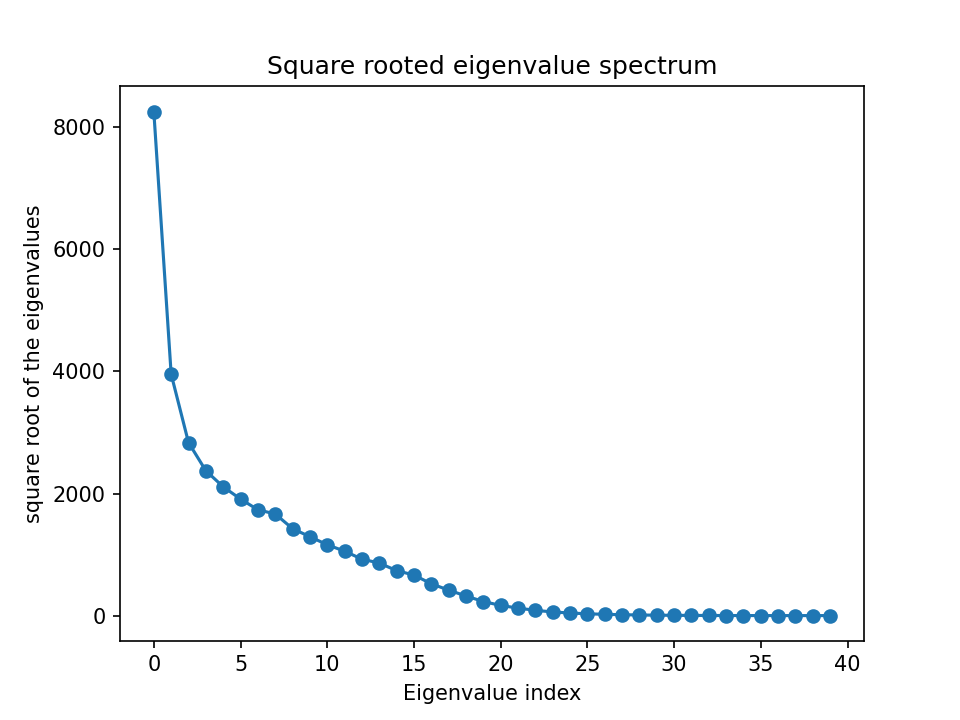

In [23]:
plt.plot(pca_ft.singular_values_, marker="o")
plt.xlabel("Eigenvalue index")
plt.ylabel("square root of the eigenvalues")
plt.title("Square rooted eigenvalue spectrum")
plt.show()

In [24]:
for i in range(len(pca_ft.singular_values_)):
    if (pca_ft.singular_values_[i] - pca_ft.singular_values_[i+2])/pca_ft.singular_values_[i+2] < 0.3:
        print("The elbow in the eigenvalue spectrum is in eigenvalue #"+str(i+1))
        break

The elbow in the eigenvalue spectrum is in eigenvalue #4


In [25]:
100*np.sum(pca_ft.explained_variance_ratio_[0:3])

76.05932223361393

<IPython.core.display.Javascript object>


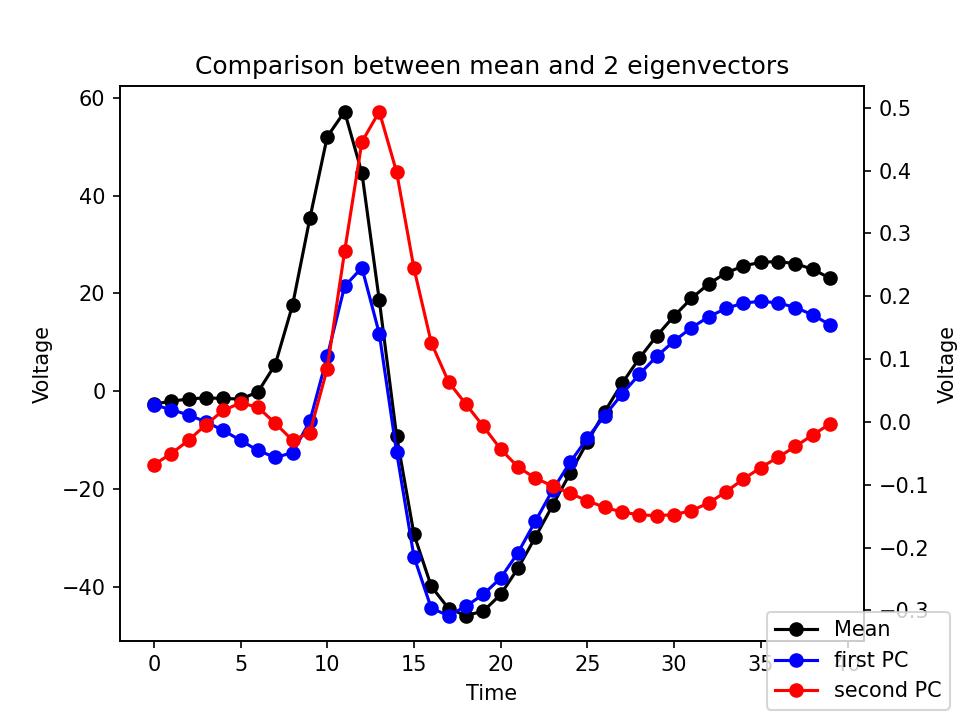

In [26]:
# Twin axis based on: https://www.geeksforgeeks.org/use-different-y-axes-on-the-left-and-right-of-a-matplotlib-plot/
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Time') 
ax1.set_ylabel('Voltage') 
ax1.plot(np.mean(first_tetrode,axis=0), marker="o", label="Mean", color="k") #[60,-40]

ax2 = ax1.twinx()   
ax2.set_ylabel('Voltage') 
ax2.plot(eigenvectors_ft[:,0], marker="o", label="first PC", color="b") #[0.2,-0.4]
ax2.plot(eigenvectors_ft[:,1], marker="o", label="second PC", color="r") 

plt.title("Comparison between mean and 2 eigenvectors")
fig.legend(loc="lower right")
plt.show()

There are no major differences, the values we are obtaining are similar and the eigenvectors plot looks also similar to the ones we obtained previously.

d. Now, consider all the channels in SpikeData12 as a single, 160x1 vector. Calculate the principal components of this larger vector. Plot the square-rooted eigenvalues - how many dominant eigenvalues do you think there are?

In [27]:
sw = SpikeWaveforms
large_vector = [np.concatenate((sw[i,:,0], sw[i,:,1], sw[i,:,2], sw[i,:,3])) for i in range(np.shape(sw)[0])]

np.shape(large_vector)

(16789, 160)

In [28]:
pca_160 = PCA()
pca_160.fit(large_vector)

eigenvectors_160 = pca_160.components_.T
print(eigenvectors_160.shape)

# Based on Caleb's code for projecting
subtraction = large_vector - np.mean(large_vector,axis=0)
z_160 = subtraction.dot(eigenvectors_160[:,:3])

(160, 160)


<IPython.core.display.Javascript object>


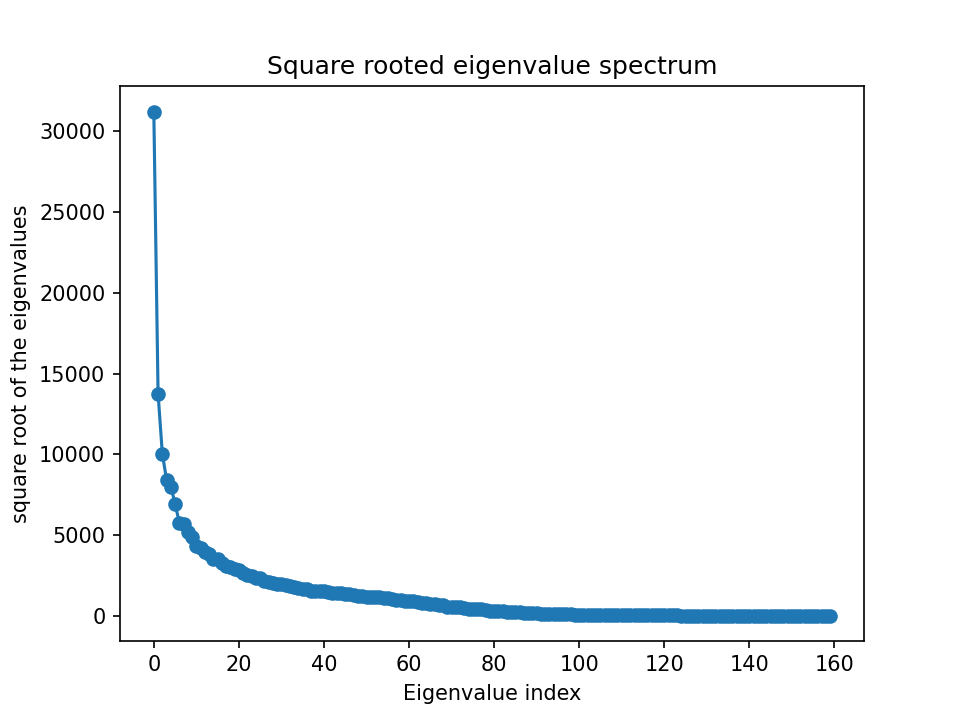

In [29]:
plt.plot(pca_160.singular_values_, marker="o")
plt.xlabel("Eigenvalue index")
plt.ylabel("square root of the eigenvalues")
plt.title("Square rooted eigenvalue spectrum")
plt.show()

In [30]:
for i in range(len(pca_160.singular_values_)):
    if (pca_160.singular_values_[i] - pca_160.singular_values_[i+2])/pca_160.singular_values_[i+2] < 0.2:
        print("The elbow in the eigenvalue spectrum is in eigenvalue #"+str(i+1))
        break

The elbow in the eigenvalue spectrum is in eigenvalue #7


In [31]:
print(100*np.sum(pca_160.explained_variance_ratio_[0:4]))
print(100*np.sum(pca_160.explained_variance_ratio_[0:5]))

73.59147378102064
77.11429072114781


Based on our previous criterium for determining dominant eigenvalues, there are 7 dominant eigenvalues. But if we change this criterion to when more than 75% of the variance is explained, we would only need the first 5 eigenvalues.

For completeness, a plot comparing the first 2 eigenvectors to the mean.

<IPython.core.display.Javascript object>


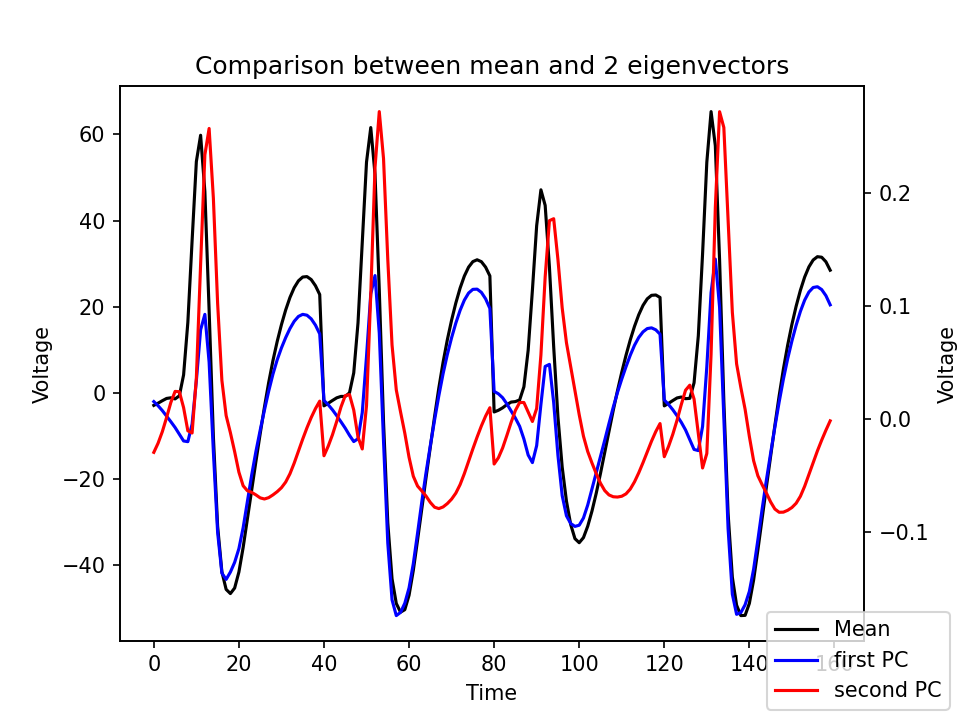

In [32]:
# Twin axis based on: https://www.geeksforgeeks.org/use-different-y-axes-on-the-left-and-right-of-a-matplotlib-plot/
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Time') 
ax1.set_ylabel('Voltage') 
ax1.plot(np.mean(large_vector,axis=0), label="Mean", color="k") #[60,-40]

ax2 = ax1.twinx()   
ax2.set_ylabel('Voltage') 
ax2.plot(eigenvectors_160[:,0], label="first PC", color="b") #[0.2,-0.4]
ax2.plot(eigenvectors_160[:,1], label="second PC", color="r") 

plt.title("Comparison between mean and 2 eigenvectors")
fig.legend(loc="lower right")
plt.show()

e. Plot and compare the mean and the first 2 principal component vectors corresponding to the first tetrode channel when PCA is done only on the single channel data versus when the PCA is done on the full 160-dimensional tetrode data of the tetrode principal components. (These will both be sets of 1x40 vectors!)

<IPython.core.display.Javascript object>


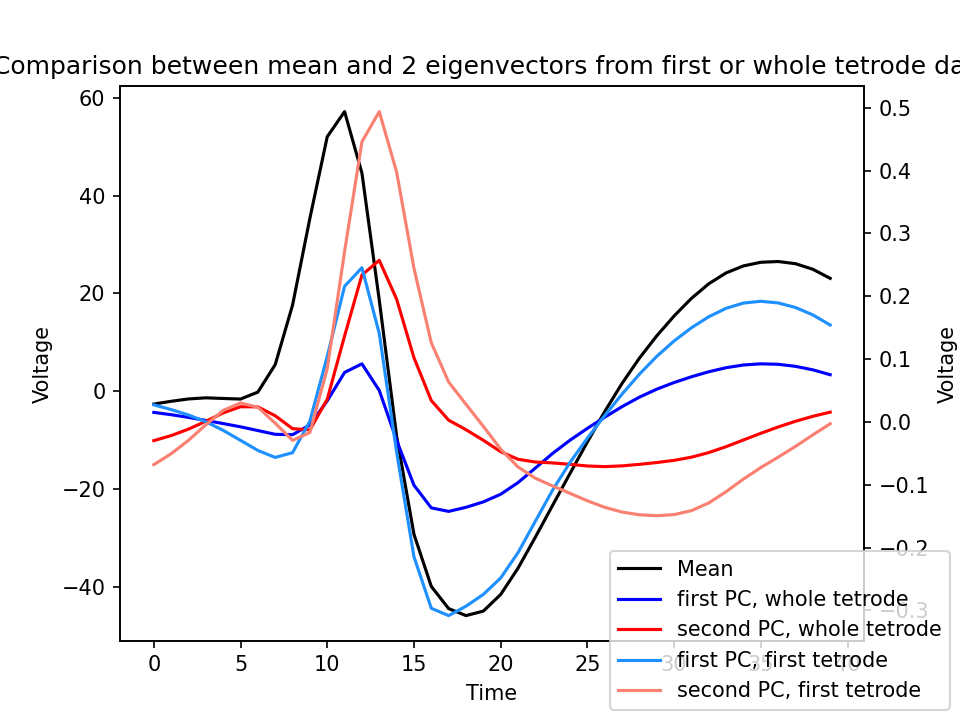

In [33]:
# Twin axis based on: https://www.geeksforgeeks.org/use-different-y-axes-on-the-left-and-right-of-a-matplotlib-plot/
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Time') 
ax1.set_ylabel('Voltage') 
ax1.plot(np.mean(first_tetrode,axis=0), label="Mean", color="k") #[60,-40]

ax2 = ax1.twinx()   
ax2.set_ylabel('Voltage') 
# Eigenvectors of the large vector
ax2.plot(eigenvectors_160[:40,0], label="first PC, whole tetrode", color="b") #[0.2,-0.4]
ax2.plot(eigenvectors_160[:40,1], label="second PC, whole tetrode", color="r") 

#Eigenvectors only from the first tetrode
ax2.plot(eigenvectors_ft[:,0], label="first PC, first tetrode", color="dodgerblue") #[0.2,-0.4]
ax2.plot(eigenvectors_ft[:,1], label="second PC, first tetrode", color="salmon") 

plt.title("Comparison between mean and 2 eigenvectors from first or whole tetrode data")
fig.legend(loc="lower right")
plt.show()

How do the values for the first channel differ from the values in the single channel analysis from (c)?

Note that for the first tetrode, the magnitude of the first two eigenvector is higher. Also note that the second PC has a peak similar to the mean of the data, while the first PC has a minimum close to the mean of the data. When we have the whole tetrode PCs, the magnitude of these waveforms diminish.

What is the difference in the fraction of the variance in the first tetrode channel captured by the 4 channel PCA vs. the single channel PCA? What about the first three principal components? Hint: Only consider the first tetrode channel. Calculate the total variance in the samples, then project into the space of the first two principal components (either single channel or full data). Back-project these into waveform space by multiplying by the principal component vectors and adding the results. Add the mean to get back to the original. Now calculate the variance (only for the first tetrode channel!) of these effectively lower dimensional waveforms, and take the ratio to the baseline.)

From Romain's question on Canvas, 

Total variance is the sum of the variance across all dimensions.

For fractions of variance, consider
$$\frac{\textrm{variance of back-projected data}}{\textrm{total variance}}$$

For calculating the variance,
$$var = np.sum(np.var(waveform1, axis=0))$$
where waveform1 is 40*NumberOfWaveforms

In [34]:
# Based on Caleb's code for projecting
subtraction = first_tetrode - np.mean(first_tetrode,axis=0)
z_160 = subtraction.dot(eigenvectors_160[:40,:2]) # Projection
z_ft = subtraction.dot(eigenvectors_ft[:,:2])

backprojection_160 = z_160.dot(eigenvectors_160[:40,:2].T) # Backprojection into the original space
backprojection_ft = z_ft.dot(eigenvectors_ft[:,:2].T)

# Adding the mean, renaming the previous variables
backprojection_160 = backprojection_160 + np.mean(backprojection_160)
backprojection_ft = backprojection_ft + np.mean(backprojection_ft)

In [35]:
# Notice this is what we wanted, the backprojection lies in the original space! 40*number_of_waveforms
print(np.shape(first_tetrode))
print(np.shape(backprojection_160))
print(np.shape(backprojection_ft))

total_var_first_electrode = np.sum(np.var(first_tetrode,axis=0))
total_var_backprojection_160 = np.sum(np.var(backprojection_160,axis=0))
total_var_backprojection_ft = np.sum(np.var(backprojection_ft,axis=0))
print(total_var_first_electrode)
print(total_var_backprojection_160)
print(total_var_backprojection_ft)

(5000, 40)
(5000, 40)
(5000, 40)
24162.70386376233
832.4888317051516
16769.84268767998


In [36]:
# Comparison between fractions of variance,
print(total_var_backprojection_160/total_var_first_electrode)
print(total_var_backprojection_ft/total_var_first_electrode)

0.03445346333750607
0.6940383320606065


Note when comparing fractions of variance, how the variance of the PCA with the first first electrode is more similar to the variance of the backprojected data. Compared to the PCA when we use the whole 160 samples, this variance is reduced by 2 orders of magnitude.

Finally, the first three principal components,

In [37]:
print(100*np.sum(pca_160.explained_variance_ratio_[0:3]))
print(100*np.sum(pca_ft.explained_variance_ratio_[0:3]))

69.6974981232747
76.05932223361393


The first tetrode PCA has a higher explained variance for its first three eigenvectors than the PCA using the whole 160 samples.

# Exercise 3

For PCA and P-PCA, the notebook makes a plot showing:

 - Each data point xn as a black dot in its native 2-D space
 - The mean, μ as a green point
 - The PC space found by either PCA or P-PCA (which is one dimensional) plotted as a line segment
 - The projection of each data point into the PC space as red points
 - A red line connecting the original and lower dimensional data

a. The lower dimensional space found by PCA and P-PCA are the same. So why are the lines in P-PCA not orthogonal as they are in the PCA case?

b. Using the code for P-PCA as a guide, implement the EM algorithm for Factor Analysis and make a plot showing the same information. Note that the lower dimensional space found by FA will pass through the mean but will not be the same as in PCA/P-PCA. Why is it different?

## The following code is taken from uploaded NB Homework5Problem3.ipynb 

In [38]:
Xsim = np.array([[  2.83717594235889647436,  11.63646180704327015576],
 [ -3.327921891190484871,    10.87319571410462337724],
 [  5.6266615323741531185,    9.06645711159280409674],
 [  6.43838210179274383904,  13.62895274146651303226],
 [ -0.73235675340731809513,   7.0584172849290567342 ],
 [ 10.95457732821499341469,  20.9159290909855073437 ],
 [ 10.94582100826051629383,   9.31802058456702120282],
 [  4.81183361703341194726,  10.56965656760404748127]])

In [39]:
# Do PCA analysis
mu = np.mean(Xsim,axis=0) # calculate mean
w,v = np.linalg.eig(np.dot((Xsim-mu).T,(Xsim-mu))) # calculate eigenvalues of covariance matrix

In [40]:
print(np.dot(Xsim-mu,v))

[[-1.51866902  1.06885836]
 [-7.00440235  3.98394604]
 [-0.71056235 -2.63696376]
 [ 2.57378213  0.6323386 ]
 [-7.06980803 -0.6296442 ]
 [10.45543239  4.00511681]
 [ 3.78876869 -5.48525481]
 [-0.51454146 -0.93839703]]


In [41]:
v[:,0] # first pca eigenvector

array([0.81871654, 0.5741979 ])

In [42]:
scores = np.dot((Xsim - mu),v[:,0]) # project into lower dimensional space
Xproj = np.outer(scores,v[:,0]) + mu # back project into original data space

In [43]:
Xproj

array([[ 3.45091217, 10.76136979],
       [-1.04034842,  7.61147321],
       [ 4.11252247, 11.22538295],
       [ 6.8014696 , 13.11124667],
       [-1.09389714,  7.57391741],
       [13.25430701, 17.63687373],
       [ 7.79619919, 13.80888941],
       [ 4.27300801, 11.33793773]])

Text(0.5, 1.0, 'PCA dimensionality reduction')

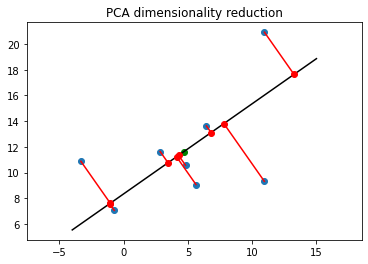

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(Xsim[:,0],Xsim[:,1],'o')
plt.plot(mu[0],mu[1],'go')
x = np.linspace(-4,15)
y = v[1,0]/v[0,0] * (x - mu[0]) + mu[1]
plt.plot(x,y,'k')

plt.plot(Xproj[:,0], Xproj[:,1], 'ro')
for x, y in zip(Xsim, Xproj):
    plt.plot([x[0],y[0]], [x[1],y[1]], 'r-')
    
plt.axis('equal')
plt.title('PCA dimensionality reduction')

### Latent variable model of Dimensionality Reduction (P-PCA)

 - Latent variable $\mathbf{z} \in \mathcal{R}^M \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
 - Data $\mathbf{x} \in \mathcal{R}^D = W \mathbf{x} + \mu + \epsilon$, where $\epsilon \sim 
     \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{I})$.
 - Model parameters are $W \sim M \times D$ and $\sigma^2$
     

### _A posteriori_ distribution of latent variable

$$
\begin{align}
\Pr(\mathbf{z} \mid \mathbf{x}) &= \mathcal{N}( E[\mathbf{z}], \mathrm{Cov}(\mathbf{z})) \\
&= \mathcal{N}(W^T C^{-1} (\mathbf{x} - \mu), \mathbf{I} - W^T C^{-1} W)
\end{align}$$
where $C = W W^T + \sigma^2 \mathbf{I}$ is the covariance of the marginal $\Pr(x)$.

### EM algorithm for P-PCA
 1. Initialize parameters
 2. **E-step:** Calculate $\Pr(\mathbf{z}_n \mid \mathbf{x}_n)$ for each data point. You will need the mean of this
 distribution, $E[\mathbf{z}_n]$ and the outer product 
 $E[\mathbf{z}_n \, \mathbf{z}_n^T] = \mathrm{Cov}(\mathbf{z}_n) + 
     E[\mathbf{z}_n] E[\mathbf{z}_n]^T$
 3. **M-step:** Update $W$ and $\sigma^2$
 
     $$W_{new} = \left( \sum_{n=1}^N (\mathbf{x}-\mu) \; E[\mathbf{z}_n]^T \right) 
     \left(\sum_{n=1}^N E[\mathbf{z} \, \mathbf{z}^T] \right)^{-1}$$
     
     $$\sigma_{new}^2 = \frac{1}{N D} \mathrm{Tr} \left( \sum_{n=1}^N (\mathbf{x}-\mu) (\mathbf{x}-\mu)^T -
     W_{new} \sum_{n=1}^N E[\mathbf{z}_n] (\mathbf{x}-\mu)^T \right)$$
     
 4. Iterate until convergence (or just a bunch of times)

In [45]:
D = Xsim.shape[1]
N = Xsim.shape[0]
M = 1
# EM for P-PCA

# Initialize parameters
Wnew = np.random.randn(D,1)
sigNew = 0.5

# Note that differently from our normal convention, Xsim is an NxD matrix.
# That means each observation is a row vector rather than a column vector.
# The result is that Ez ends up being a row vector (EzzT is properly square).
for i in range(5000):
    Wold = Wnew
    sigOld = sigNew
    C = Wold.dot(Wold.T) + sigOld*np.eye(D) # covariance of P(x)
    Ez = Wold.T.dot(np.linalg.inv(C)).dot((Xsim - mu).T) # W^T C^-1 (x - mu)
    EzzT = (np.eye(M) - Wold.T.dot(np.linalg.inv(C)).dot(Wold))*N + (Ez.dot(Ez.T)) # Cov(z) + Ez Ez^T
    Wnew = ((Xsim - mu).T).dot(Ez.T) # break it into two lines - first product of (x-mu) and Ez
    Wnew = Wnew.dot(np.linalg.inv(EzzT)) # then scale down by EzzT
    sigNew = 1/(N*D) * np.trace((Xsim - mu).T.dot(Xsim-mu) - Wnew.dot(Ez.dot(Xsim-mu))) # Note that the transposes 
                                                    # are in the opposite order than above because of dims of Xsim
    

In [46]:
# Now, we want to compare PPCA dimensions to PCA dimensions
u1,s1,v1 = np.linalg.svd(Wnew)
u1[:,0]

array([0.81871654, 0.5741979 ])

In [47]:
C = Wnew.dot(Wnew.T) + sigNew*np.eye(D)
z_ppca = Wnew.T.dot(np.linalg.inv(C)).dot((Xsim - mu).T)
Xproj_ppca = (Wnew.dot(z_ppca)).T + mu

Text(0.5, 1.0, 'P-PCA')

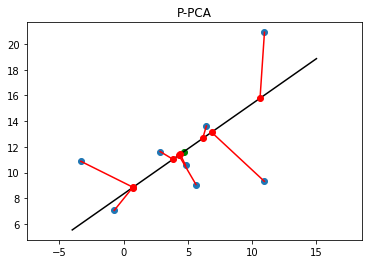

In [48]:
plt.plot(Xsim[:,0],Xsim[:,1],'o')
plt.plot(mu[0],mu[1],'go')
x = np.linspace(-4,15)
y = Wnew[1]/Wnew[0] * (x - mu[0]) + mu[1]
plt.plot(x,y,'k')

plt.plot(Xproj_ppca[:,0], Xproj_ppca[:,1], 'ro')
for x, y in zip(Xsim, Xproj_ppca):
    plt.plot([x[0],y[0]], [x[1],y[1]], 'r-')
    
plt.axis('equal')
plt.title('P-PCA')


### Latent variable model of Dimensionality Reduction (Factor Analysis)

 - Latent variable $\mathbf{z} \in \mathcal{R}^M \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
 - Data $\mathbf{x} \in \mathcal{R}^D = W \mathbf{x} + \mu + \epsilon$, where $\epsilon \sim 
     \mathcal{N}(\mathbf{0}, \Psi)$.
 - Model parameters are $W \sim M \times D$ and $\Psi$
     
The difference between P-PCA and FA is that in FA, the observation noise is a diagonal matrix, $\Psi$, rather
than a diagonal matrix with constant value, $\sigma^2 \mathbf{I}$.

### _A posteriori_ distribution of latent variable

$$
\begin{align}
\Pr(\mathbf{z} \mid \mathbf{x}) &= \mathcal{N}( E[\mathbf{z}], \mathrm{Cov}(\mathbf{z})) \\
&= \mathcal{N}(W^T C^{-1} (\mathbf{x} - \mu), \mathbf{I} - W^T C^{-1} W)
\end{align}$$
where $C = W W^T + \Psi$ is the covariance of the marginal $\Pr(x)$. **(Note that this is different than P-PCA!)**

### EM algorithm for Factor Analysis
 1. Initialize parameters
 2. **E-step:** Calculate $\Pr(\mathbf{z}_n \mid \mathbf{x}_n)$ for each data point. You will need the mean of this
 distribution, $E[\mathbf{z}_n]$ and the outer product 
 $E[\mathbf{z}_n \, \mathbf{z}_n^T] = \mathrm{Cov}(\mathbf{z}_n) + 
     E[\mathbf{z}_n] E[\mathbf{z}_n]^T$
 3. **M-step:** Update $W$ and $\Psi$
 
     $$W_{new} = \left( \sum_{n=1}^N (\mathbf{x}-\mu) \; E[\mathbf{z}_n]^T \right) 
     \left(\sum_{n=1}^N E[\mathbf{z} \, \mathbf{z}^T] \right)^{-1}$$
     
     $$\Psi_{new} = \frac{1}{N} \mathrm{diag} \left( \sum_{n=1}^N (\mathbf{x}-\mu) (\mathbf{x}-\mu)^T -
     W_{new} \sum_{n=1}^N E[\mathbf{z}_n] (\mathbf{x}-\mu)^T \right)$$
     
     where "$\mathrm{diag}()$" means to zero the off-diagonal elements.
     
 4. Iterate until convergence (or just a bunch of times)

# Exercise 3
a. The lower dimensional space found by PCA and P-PCA are the same. So why are the lines in P-PCA not orthogonal as they are in the PCA case?

In the covariance matrix in PCA, there is only one source of variability due to the projection of the data. In the covariance matrix for P-PCA, there is not only the source of variability due to the data projection, but there is also another one due to noise. This noise projection explains why the lines are not orthogonal.

b. Using the code for P-PCA as a guide, implement the EM algorithm for Factor Analysis and make a plot showing the same information. Note that the lower dimensional space found by FA will pass through the mean but will not be the same as in PCA/P-PCA. Why is it different?

In [49]:
# Modified code for P-PCA that works for Factor Analysis 

D = Xsim.shape[1]
N = Xsim.shape[0]
M = 1
# EM for P-PCA

# Initialize parameters
Wnew = np.random.randn(D,1)
# sigNew = 0.5 # Instead of a sigNew, we want a diagonal matrix
psi = np.diag([0.5 for i in range(2)])

for i in range(5000):
    Wold = Wnew
    # sigOld = sigNew # We must change this
    C = Wold.dot(Wold.T) + psi #sigOld*np.eye(D) # covariance of P(x)
    Ez = Wold.T.dot(np.linalg.inv(C)).dot((Xsim - mu).T) # W^T C^-1 (x - mu)
    EzzT = (np.eye(M) - Wold.T.dot(np.linalg.inv(C)).dot(Wold))*N + (Ez.dot(Ez.T)) # Cov(z) + Ez Ez^T
    Wnew = ((Xsim - mu).T).dot(Ez.T) # break it into two lines - first product of (x-mu) and Ez
    Wnew = Wnew.dot(np.linalg.inv(EzzT)) # then scale down by EzzT
    psi = 1/N * np.diag((Xsim - mu).T.dot(Xsim-mu) - Wnew.dot(Ez.dot(Xsim-mu))) # Note that the transposes
                                                    # are in the opposite order than above because of dims of Xsim
    

In [50]:
# Now, we want to compare PPCA dimensions to PCA dimensions
u1,s1,v1 = np.linalg.svd(Wnew)
u1[:,0]

array([-0.903778  ,  0.42800154])

In [51]:
C = Wnew.dot(Wnew.T) + psi # Here we added psi instead of the identity times sigma squared
z_ppca = Wnew.T.dot(np.linalg.inv(C)).dot((Xsim - mu).T)
Xproj_ppca = (Wnew.dot(z_ppca)).T + mu

Text(0.5, 1.0, 'Factor Analysis')

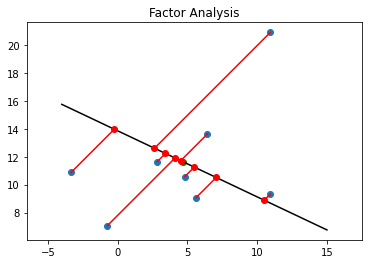

In [52]:
plt.plot(Xsim[:,0],Xsim[:,1],'o')
plt.plot(mu[0],mu[1],'go')
x = np.linspace(-4,15)
y = Wnew[1]/Wnew[0] * (x - mu[0]) + mu[1]
plt.plot(x,y,'k')

plt.plot(Xproj_ppca[:,0], Xproj_ppca[:,1], 'ro')
for x, y in zip(Xsim, Xproj_ppca):
    plt.plot([x[0],y[0]], [x[1],y[1]], 'r-')
    
plt.axis('equal')
plt.title('Factor Analysis')

Note that in Factor Analysis, the lower projected dimensional space is affected by possible rotations, which are given by the covariance matrix in the form of the diagonal matrix $\psi$. Basically, we are adding ellipsoid noise to each datapoint in factor analysis. Meanwhile, in P-PCA, we are adding a sphere of noise to each datapoint, so there is no rotation in this method. That is why the lower dimensional space is rotated around the mean. And when we compare P-PCA to factor analysis, we could think that the lower dimensional space is tilted.